In [23]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from crp.image import imgify, vis_opaque_img, plot_grid

In [24]:
from expbasics.leemann import disjoint_orthogonality_loss, nearest_neighbors, vis_nearest_neighbors
from expbasics.helper import get_attributions, get_model_etc, get_dr_methods, get_centroids, get_cavs
from expbasics.network import train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import BiasedNoisyDataset
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution
from expbasics.visualizations import visualize_dr, data_iterations, ground_truth_plot
from torch.utils.data import Dataset, DataLoader, random_split

%reload_ext autoreload
%autoreload 2

In [25]:
BIAS = 0.8
BATCH_SIZE = 128
N_BASIS = 2
STRENGTH = 0.5
LR = 0.001

LAYER_NAME = "linear_layers.0"

model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS)
methods, names = get_dr_methods()

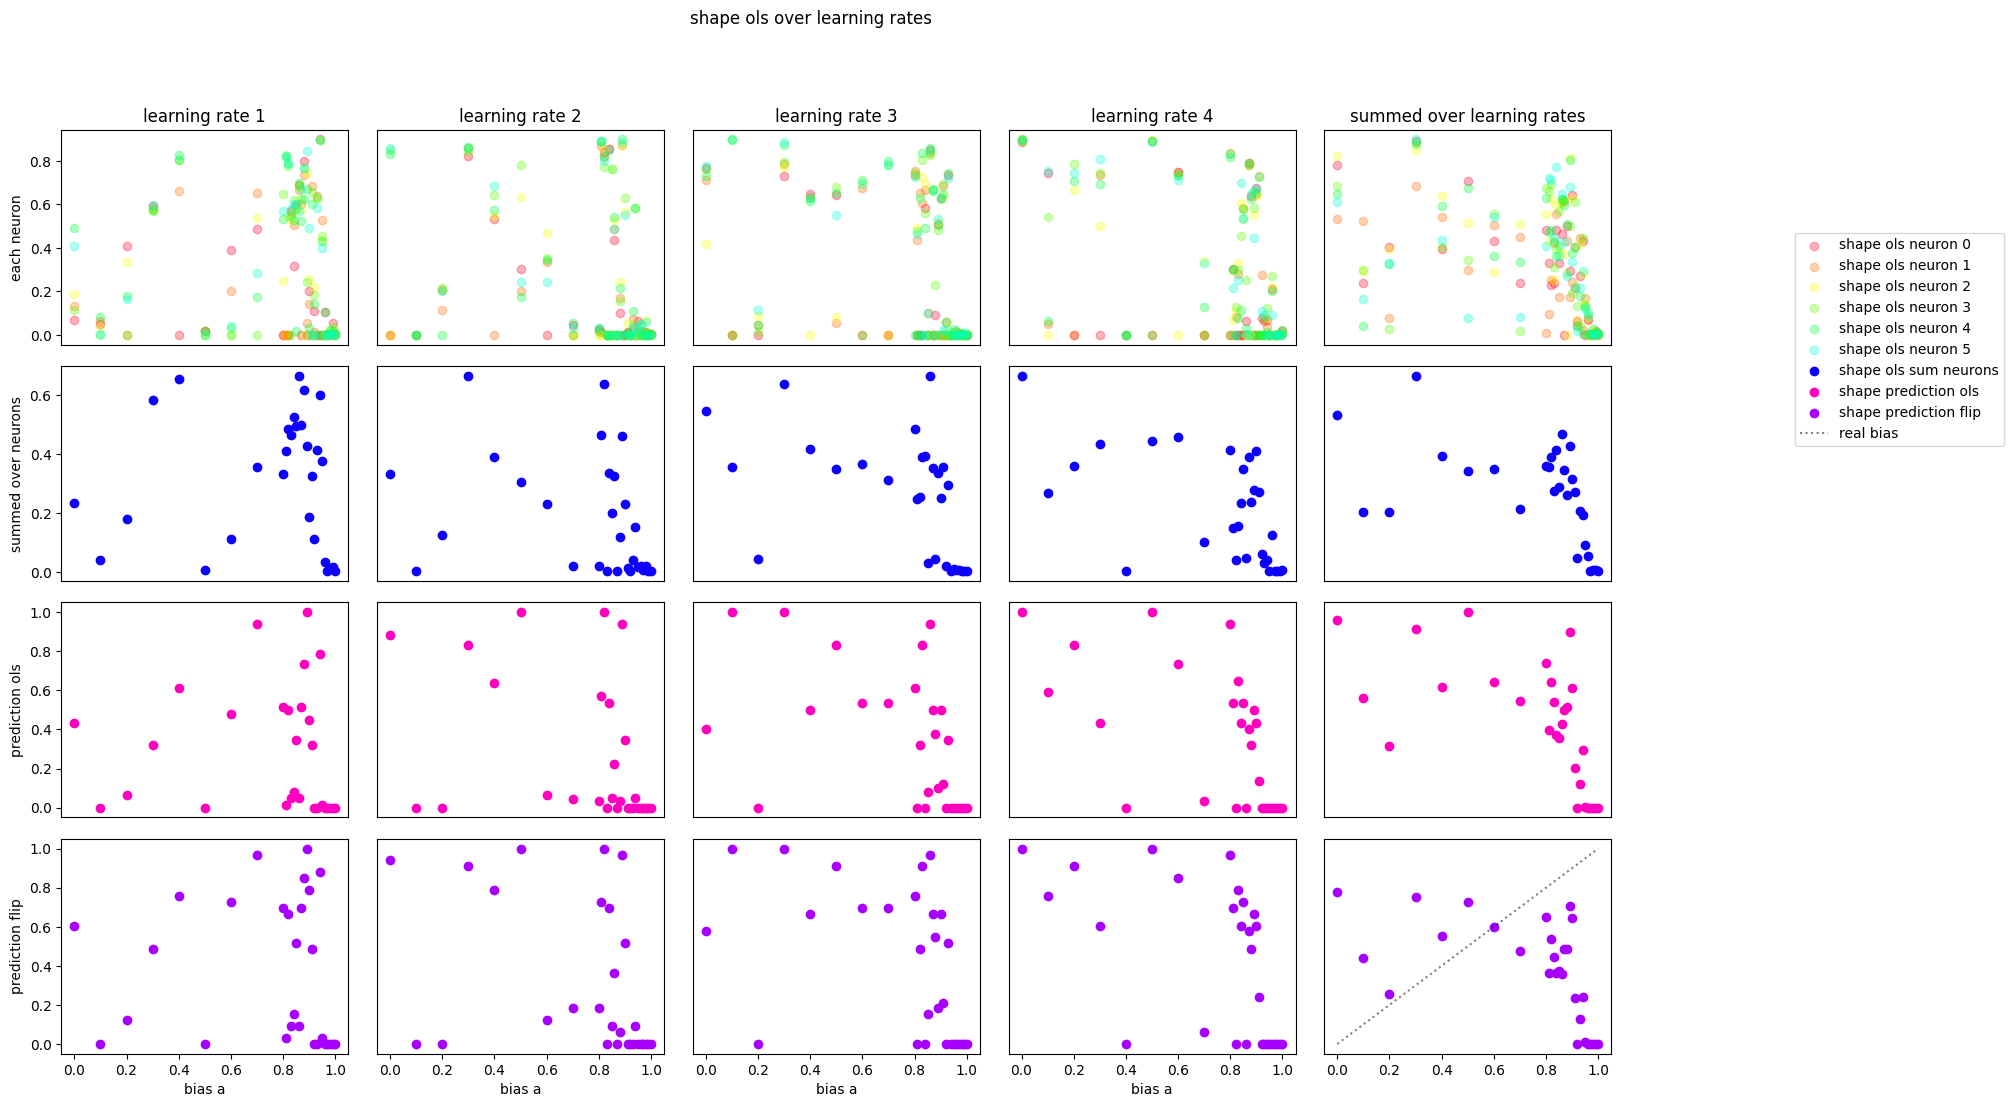

In [29]:
datas, filtbiases = data_iterations("outputs/noisy_accuracies.json")

ground_truth_plot(datas, filtbiases, 1, m_type="ols")


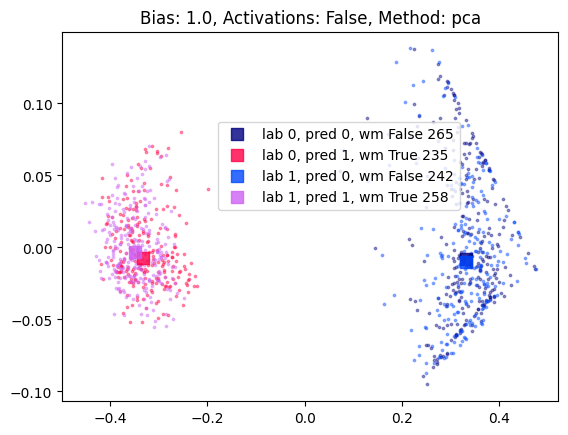

In [31]:
BIASES = filtbiases#np.round(np.linspace(0, 1, 11), 3)
ACTIVATIONS = False
METHOD = 0
all_centroids = {}
all_distances = {}

for bias in BIASES:
    for num_it in range(1):
        model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(bias, num_it=num_it)
        #idx, cavs = get_cavs(model, unbiased_ds, activations=ACTIVATIONS)
        #res = methods[METHOD].fit_transform(cavs.numpy())
        vector, watermarks, predictions, labels, idx = get_attributions(model, ACTIVATIONS, gm, crp_attribution)
        centroids = visualize_dr(
            methods, names, vector, watermarks, labels, predictions, bias, ACTIVATIONS, num_it
        )
        all_centroids[str(bias)] = centroids


array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])